In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from glob import glob
from tqdm.notebook import tqdm

plt.style.use("seaborn")

BASE = "/media/giani/Gianicosas/Magister/Proyecto/"

# Datos

In [3]:
df = pd.read_csv(f"{BASE}work_data/matriz_desercion_4_no_dummy.csv.gz")
df.head()

,gen_alu,tipo_inst_1,jornada,dur_estudio_carr,dur_proceso_tit,region_sede,area_conocimiento,acreditada_carr,acreditada_inst,desertor_1,...,prom_notas_media,dependencia_colegio,fscu,gratuidad,beca,dif_ing_ult_mat,Edad,valor_arancel,misma_region,sub_tipo_inst
0,mujer,Centros de Formación Técnica,Vespertino,4,1,Metropolitana,Administración y Comercio,NO ACREDITADA,ACREDITADA,1,...,6.4,Particular Subvencionado,0,0,0,0,35,1390000.0,1,cft_privado
1,hombre,Institutos Profesionales,Vespertino,5,1,Metropolitana,Tecnología,ACREDITADA,ACREDITADA,1,...,5.5,Particular Subvencionado,0,0,1,0,31,1850000.0,1,ip_privado_precencia_nacional
2,hombre,Centros de Formación Técnica,Vespertino,6,1,Maule,Tecnología,NO ACREDITADA,NO ACREDITADA,0,...,4.7,Particular Subvencionado,0,0,0,0,29,803000.0,1,cft_privado
3,hombre,Institutos Profesionales,Vespertino,5,1,Metropolitana,Tecnología,NO ACREDITADA,ACREDITADA,0,...,6.0,Municipal,0,0,0,0,29,1690000.0,1,ip_privado_precencia_nacional
4,mujer,Institutos Profesionales,Diurno,5,1,Metropolitana,Derecho,NO ACREDITADA,ACREDITADA,0,...,6.4,Particular Subvencionado,0,0,0,0,16,1480000.0,1,ip_privado_precencia_nacional


# Instituciones con mayor deserción

Considerando desertores únicos en ventana de periodo

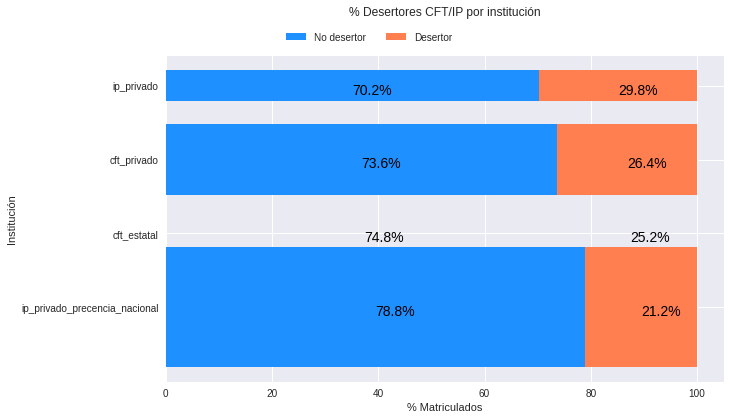

In [11]:
cross_tab_prop = pd.crosstab(index=df['sub_tipo_inst'],
                             columns=df['desertor_1'],
                             normalize="index").sort_values(by=[1.0])

cross_tab = pd.crosstab(index=df['sub_tipo_inst'],
                        columns=df['desertor_1']).reindex(index = cross_tab_prop.index)

w = np.array(cross_tab.T.sum()/cross_tab.T.sum().sum()) * 3

f, ax = plt.subplots(figsize=(10,6))
plt.rcParams.update({'font.size': 15})

plt.title("% Desertores CFT/IP por institución", pad=40)

b1 = plt.barh(cross_tab_prop.reset_index()['sub_tipo_inst'],
                cross_tab_prop.reset_index()[0], 
                color="dodgerblue",
                height=w)

b2 = plt.barh(cross_tab_prop.reset_index()['sub_tipo_inst'],
                cross_tab_prop.reset_index()[1], 
                left=cross_tab_prop.reset_index()[0], 
                color="coral",
                height=w)
                
for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=14)
        
plt.xticks(np.arange(0, 1.2, 0.2), range(0, 120, 20))

ax.legend(['No desertor', 'Desertor'], loc ='upper left', ncol=2, bbox_to_anchor=(0.2,1.1));
plt.xlabel("% Matriculados");
plt.ylabel("Institución");